# Перенос обучения: Семинар 1

## Часть 1: Используем классификатор картинок

### Изучим наше окружение

In [1]:
import torch
from utils import IMAGENET_LABELS

In [2]:
x = torch.rand(5, 3)
print(x)

tensor([[0.1116, 0.2137, 0.5010],
        [0.3178, 0.0149, 0.4532],
        [0.9392, 0.6918, 0.9005],
        [0.0114, 0.6528, 0.5470],
        [0.7714, 0.8808, 0.0082]])


In [3]:
torch.cuda.is_available()

False

In [4]:
torch.__version__ # собирал из source torch whl https://disk.yandex.ru/d/B6rLgSMmk6CvcQ под устаревшее оборудование (здесь не использую)

'2.4.0+cpu'

### Скачиваем одно изображение

Возьмем картинку из OpenImages V5 Dataset

https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_resnet.ipynb#scrollTo=3508095b

In [5]:
%matplotlib --list

Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'macosx', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wx', 'wxagg', 'wxcairo']


In [6]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [7]:
%matplotlib inline

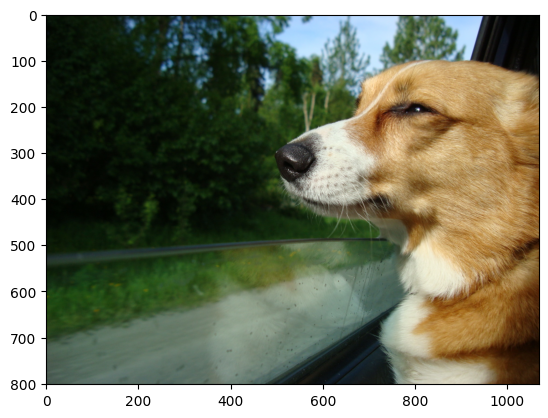

In [8]:
# В Colab/Linux это можно сделать через утилиту wget
#!wget -O corgi.jpg https://farm4.staticflickr.com/1301/4694470234_6f27a4f602_o.jpg

# В Windows/универсально можно скачать файл через библиотеку urllib
import urllib.request
url = 'https://farm4.staticflickr.com/1301/4694470234_6f27a4f602_o.jpg'
filename = 'corgi.jpg'
urllib.request.urlretrieve(url, filename)

from PIL import Image
from matplotlib import pyplot as plt

img = Image.open('corgi.jpg');
plt.imshow(img);

### Загрузим модель

Модели Resnet были предложены в статье [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Начать использование удобно с одной из 5 самых распространенных версий модели, которые содержат 18, 34, 50, 101, 152 слоя соответственно.

Чем глубже модель, тем меньше ошибок она совершает (на данных ImageNet, на которых она обучалась).

| Вид модели | Top-1 error | Top-5 error |
| --------------- | ----------- | ----------- |
|  resnet18       | 30.24       | 10.92       |
|  resnet34       | 26.70       | 8.58        |
|  resnet50       | 23.85       | 7.13        |
|  resnet101      | 22.63       | 6.44        |
|  resnet152      | 21.69       | 5.94        |

Откуда берутся эти модели: https://pytorch.org/vision/stable/models.html#classification

In [9]:
model = torch.hub.load( 'pytorch/vision:v0.10.0', 'resnet18', pretrained=True )

model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Using cache found in C:\Users\admin/.cache\torch\hub\pytorch_vision_v0.10.0


### Объявим названия классов ImageNet

Пример такой таблицы: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [11]:
IMAGENET_LABELS[100]

'black swan, Cygnus atratus'

### Предобработка картинки

Все эти предобученные модели ожидают, что входные изображения будут нормализованы одинаковым образом, т.е. пакеты 3-канальных изображений RGB размерности `(3 x H x W)`, где высота и ширина изображения равна минимум 224.

Значения пикселей должны быть переведены в диапазон, `[0, 1]` а затем нормализованы с помощью `mean = [0.485, 0.456, 0.406]` и `std = [0.229, 0.224, 0.225]` (числа из статьи).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


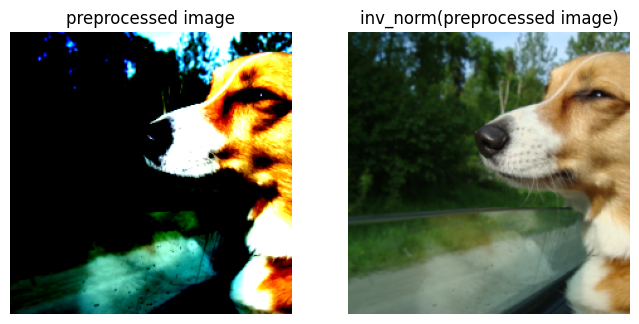

In [12]:
# Предобработка для этой конкретной нейросети
from torchvision import transforms
norm = transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )

inv_norm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

image_tensor = preprocess(img)
input_tensor = image_tensor.unsqueeze(0) # Модель ожидает одно изображение ("один батч")
input_tensor = input_tensor.to(device) # Отправим тензор на выбранное устройство (CPU/GPU/TPU)

# Покажем картинку после предобработки и после обратной трансформации
fig, ax = plt.subplots(1, 2, figsize=(8, 4));
mnc_tensor = image_tensor.permute(1, 2, 0); # (C, M, N) -> (M, N, C)
ax[0].imshow(mnc_tensor);
ax[0].axis('off');
ax[0].set_title('preprocessed image');
inv_norm_tensor = inv_norm(image_tensor).permute(1, 2, 0);
ax[1].imshow(inv_norm_tensor);
ax[1].axis('off');
ax[1].set_title('inv_norm(preprocessed image)');

### Предскажем класс одной картинки

In [13]:
# Single prediction call
outputs = model( input_tensor )
print('outputs.device == {}'.format(outputs.device))
prediction = outputs.max(dim=1).indices.item()
print('ResNet50 prediction: {}'.format(IMAGENET_LABELS[prediction]))

outputs.device == cpu
ResNet50 prediction: Pembroke, Pembroke Welsh corgi


In [14]:
prediction

263

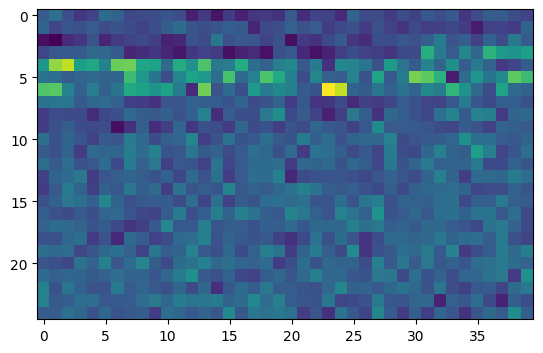

In [15]:
out1 = outputs.cpu().detach()
plt.imshow( out1.reshape(25,-1) )

## Задание №1: Создайте функцию для предсказания класса картинок

Скопируйте релевантный код в функцию, которая возвращает текстовую метку класса изображения.

In [16]:
def preprocess_image(image_path: str, device: torch.device) -> torch.Tensor:
 """
 Преобразует изображение в тензор, добавляет размерность для батча
 и перемещает тензор на указанное устройство (CPU/GPU).

 Параметры:
 - image_path (str): Путь к изображению.
 - device (torch.device): Устройство для размещения тензора (CPU или GPU).

 Возвращает:
 - torch.Tensor: Тензор изображения, готовый для подачи в модель.
 """
 try:
  img = Image.open(image_path).convert('RGB')  # Конвертация в RGB для согласованности
 except Exception as e:
  raise ValueError(f"Не удалось открыть изображение {image_path}: {e}")

 image_tensor = preprocess(img)  # Предполагается, что preprocess определён ранее
 input_tensor = image_tensor.unsqueeze(0)  # Добавление размерности для батча
 input_tensor = input_tensor.to(device)     # Перемещение на выбранное устройство

 return input_tensor

In [17]:
def class_of_picture(model, image_path, device, labels=IMAGENET_LABELS):
 """
 Возвращает текстовую метку класса изображения, предсказанного моделью.
 
 Параметры:
 - model: обученная модель.
 - image_path (str): Путь к входному изображению.
 - device (torch.device): Устройство для размещения тензора (CPU или GPU).
 - labels: список текстовых меток (например, IMAGENET_LABELS).
 
 Возвращает:
 - str: Текстовая метка класса.
 """
 input_tensor = preprocess_image(image_path, device)

 # Выполнение предсказания
 with torch.no_grad():  # Отключение градиентов для ускорения и экономии памяти
  outputs = model(input_tensor)

 # Получение индекса с максимальным значением по размерности 1
 _, prediction_idx = torch.max(outputs, 1)
 prediction = prediction_idx.item()

 # Возвращение текстовой метки
 return labels[prediction]


In [18]:
def prepare_tensor_for_display(torch_tensor: torch.Tensor) -> torch.Tensor:
 """
 Преобразует тензор изображения для отображения,
 выполняя транспонирование и обрезку значений в допустимый диапазон [0, 1].

 Параметры:
 - torch_tensor (torch.Tensor): Тензор изображения с размерностью (C, M, N).

 Возвращает:
 - torch.Tensor: Тензор с размерностью (M, N, C), готовый для отображения.
 """
 tensor = torch_tensor.permute(1, 2, 0)  # (C, M, N) -> (M, N, C)
 tensor = torch.clamp(tensor, 0, 1)  # Обрезка значений в диапазон [0, 1]
 return tensor


In [19]:
def show_preprocess_image(torch_tensor: torch.Tensor) -> None:
 """
 Отображает изображение до и после обратной нормализации.

 Параметры:
 - torch_tensor (torch.Tensor): Тензор изображения с размерностью (C, M, N), 
   где C - количество каналов, M и N - высота и ширина изображения соответственно.

 Возвращает:
 - None: Функция ничего не возвращает, только отображает изображения.
 """
 # Покажем картинку после предобработки и после обратной трансформации
 fig, ax = plt.subplots(1, 2, figsize=(8, 4));

 # Преобразование (C, M, N) -> (M, N, C)
 mnc_tensor = prepare_tensor_for_display(torch_tensor)
 ax[0].imshow(mnc_tensor);
 ax[0].axis('off');
 ax[0].set_title('preprocessed image');

 # Обратная нормализация и преобразование
 inv_norm_tensor = prepare_tensor_for_display(inv_norm(torch_tensor)) 
 ax[1].imshow(inv_norm_tensor);
 ax[1].axis('off');
 ax[1].set_title('inv_norm(preprocessed image)');

 plt.show()

In [20]:
url = 'https://images.unsplash.com/photo-1725015487404-329db13bb882'
filename = 'rain.jpg'
urllib.request.urlretrieve(url, filename)

label = class_of_picture( model, filename, device )
print('ResNet34 prediction:', label)

ResNet34 prediction: umbrella


Теперь задействуйте функцию в простой задаче

1. Найдите URL любого изображения (например с [unsplash](https://unsplash.com/))
2. Классифицируйте изображение с помощью вашей функции `class_of_picture`

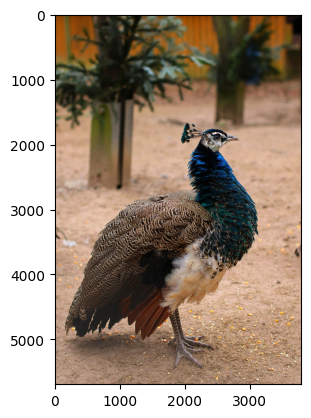

In [21]:
url = 'https://images.unsplash.com/photo-1705355319494-b9e98e0371b4'
filename = 'peacock.jpg'
urllib.request.urlretrieve(url, filename)

img = Image.open('peacock.jpg');
plt.imshow(img);

In [22]:
image_tensor = preprocess(img)
input_tensor = image_tensor.unsqueeze(0) # Модель ожидает одно изображение ("один батч")
input_tensor = input_tensor.to(device) # Отправим тензор на выбранное устройство (CPU/GPU/TPU)

# Single prediction call
outputs = model( input_tensor )
print('outputs.device == {}'.format(outputs.device))
prediction = outputs.max(dim=1).indices.item()
print('ResNet50 prediction: {}'.format(IMAGENET_LABELS[prediction]))


outputs.device == cpu
ResNet50 prediction: peacock


ResNet34 prediction: peacock


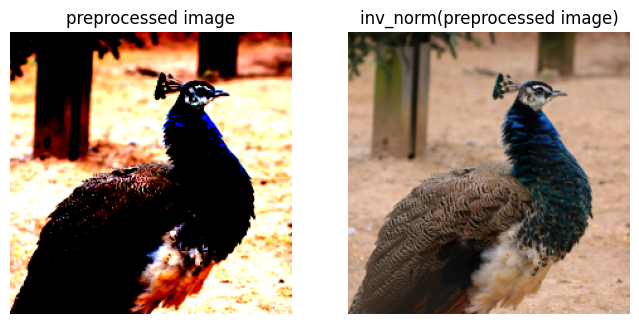

In [23]:
# Загрузите изображение
# Получите его класс
label = class_of_picture( model, filename, device )
print('ResNet34 prediction:', label)
show_preprocess_image(image_tensor)


### Можно ли "укрупнить" классы ImageNet?

Сейчас можно найти статьи по объединению текстовых меток по пересечению датасетов (пример: https://arxiv.org/pdf/1612.08242.pdf).

Но это было до крупных лингвистических моделей.

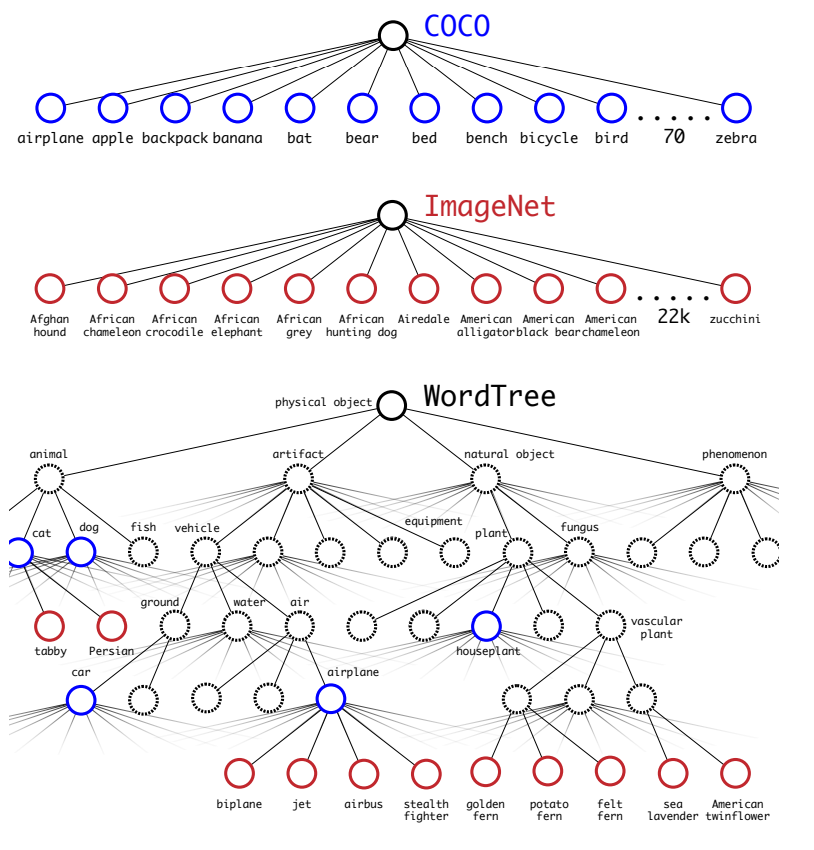